# Predictive Engine: Building Energy Efficiency
## M4U1 Assignment – Data Analytics for AECO
---
**Objective:** Use historical building data to predict heating load using two ML models, compare them, and optimise the winner.

**Dataset:** UCI Machine Learning Repository – Energy Efficiency Dataset (768 samples, 8 features)

**Target Variable:** Heating Load (Y1) — the energy required to heat a building (kWh/m²)

**Models:** Linear Regression vs. Random Forest Regressor

## 1. Setup & Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
print('All libraries imported successfully.')

All libraries imported successfully.


## 2. Data Loading

In [4]:
# Load from UCI ML Repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
df = pd.read_excel(url)

# Rename columns for readability
df.columns = ['Rel_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
              'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Dist',
              'Heating_Load', 'Cooling_Load']

print(f'Dataset shape: {df.shape}')
print(f'\nFeatures: {list(df.columns[:8])}')
print(f'Targets:  {list(df.columns[8:])}')
df.head(10)

Dataset shape: (768, 10)

Features: ['Rel_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Dist']
Targets:  ['Heating_Load', 'Cooling_Load']


,Rel_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Dist,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
5,0.90,563.5,318.5,122.50,7.0,3,0.0,0,21.46,25.38
6,0.90,563.5,318.5,122.50,7.0,4,0.0,0,20.71,25.16
7,0.90,563.5,318.5,122.50,7.0,5,0.0,0,19.68,29.60
8,0.86,588.0,294.0,147.00,7.0,2,0.0,0,19.50,27.30
9,0.86,588.0,294.0,147.00,7.0,3,0.0,0,19.95,21.97


## 3. Data Cleaning & Exploration

In [5]:
# Check for missing values
print('Missing values per column:')
print(df.isnull().sum())
print(f'\nDuplicate rows: {df.duplicated().sum()}')
print('\nBasic Statistics:')
df.describe().round(2)

Missing values per column:
Rel_Compactness    0
Surface_Area       0
Wall_Area          0
Roof_Area          0
Overall_Height     0
Orientation        0
Glazing_Area       0
Glazing_Dist       0
Heating_Load       0
Cooling_Load       0
dtype: int64

Duplicate rows: 0

Basic Statistics:


,Rel_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Dist,Heating_Load,Cooling_Load
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,0.76,671.71,318.50,176.60,5.25,3.50,0.23,2.81,22.31,24.59
std,0.11,88.09,43.63,45.17,1.75,1.12,0.13,1.55,10.09,9.51
min,0.62,514.50,245.00,110.25,3.50,2.00,0.00,0.00,6.01,10.90
25%,0.68,606.38,294.00,140.88,3.50,2.75,0.10,1.75,12.99,15.62
50%,0.75,673.75,318.50,183.75,5.25,3.50,0.25,3.00,18.95,22.08
75%,0.83,741.12,343.00,220.50,7.00,4.25,0.40,4.00,31.67,33.13
max,0.98,808.50,416.50,220.50,7.00,5.00,0.40,5.00,43.10,48.03


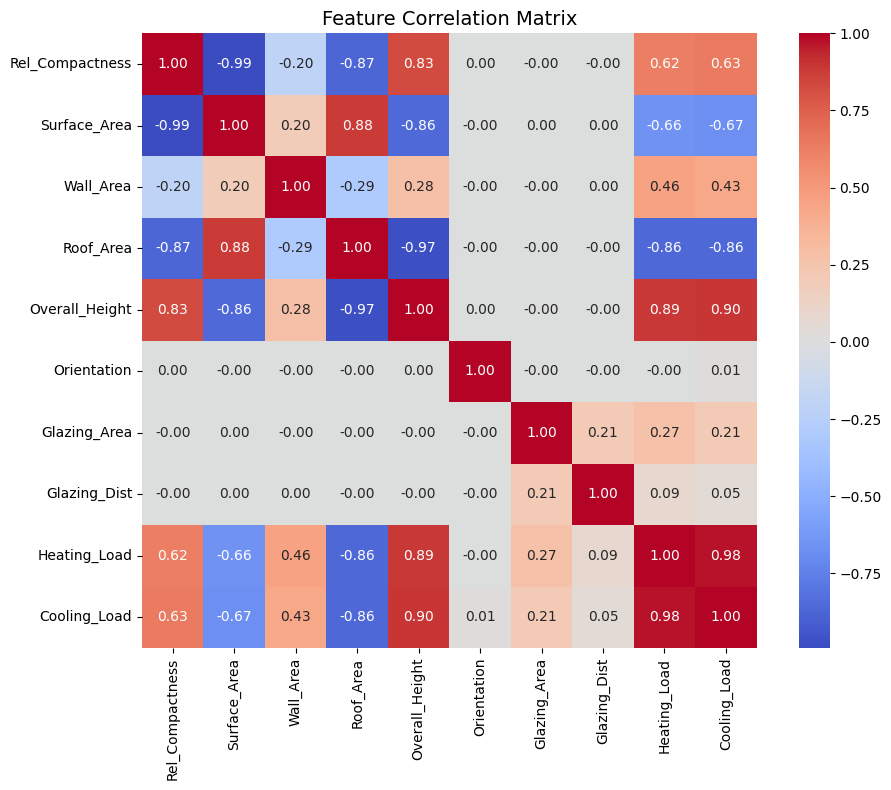

In [6]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

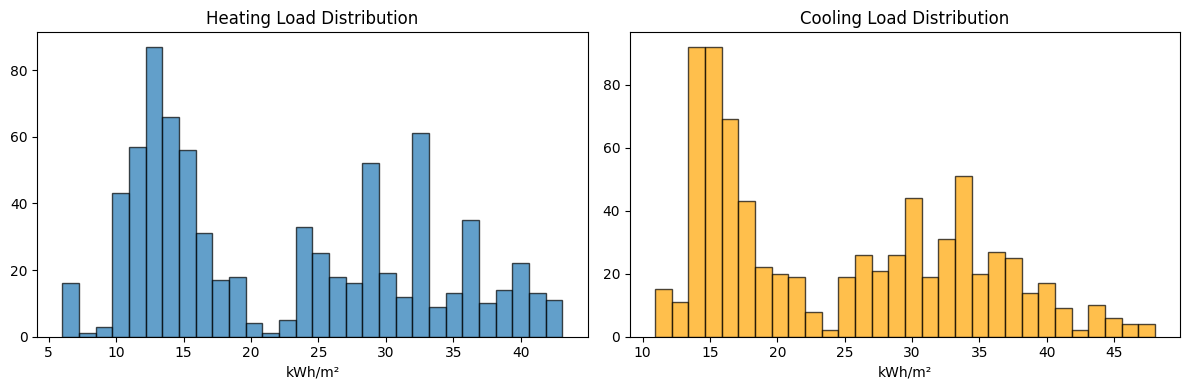

In [7]:
# Distribution of target variable
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df['Heating_Load'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Heating Load Distribution')
axes[0].set_xlabel('kWh/m²')
axes[1].hist(df['Cooling_Load'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Cooling Load Distribution')
axes[1].set_xlabel('kWh/m²')
plt.tight_layout()
plt.show()

## 4. Feature Selection & Train/Test Split
We use all 8 building parameters as features and **Heating Load** as our target.

In [8]:
features = ['Rel_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
            'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Dist']
target = 'Heating_Load'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set:     {X_test.shape[0]} samples')

# Scale features for Linear Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 614 samples
Test set:     154 samples


## 5. Model A — Linear Regression
A simple, interpretable model that assumes a linear relationship between features and the target.

In [9]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

lr_r2 = r2_score(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_mae = mean_absolute_error(y_test, y_pred_lr)

print('=== Linear Regression Results ===')
print(f'R² Score:  {lr_r2:.4f}')
print(f'RMSE:      {lr_rmse:.4f} kWh/m²')
print(f'MAE:       {lr_mae:.4f} kWh/m²')

# Coefficients
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': lr.coef_})
coef_df = coef_df.sort_values('Coefficient', key=abs, ascending=False)
print('\nFeature Coefficients (scaled):')
coef_df

=== Linear Regression Results ===
R² Score:  0.9122
RMSE:      3.0254 kWh/m²
MAE:       2.1821 kWh/m²

Feature Coefficients (scaled):


,Feature,Coefficient
4,Overall_Height,7.215464
0,Rel_Compactness,-6.517601
3,Roof_Area,-3.917367
1,Surface_Area,-3.604586
6,Glazing_Area,2.700051
2,Wall_Area,0.795339
7,Glazing_Dist,0.327345
5,Orientation,-0.035934


## 6. Model B — Random Forest Regressor
An ensemble model that can capture non-linear relationships and feature interactions.

In [10]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)

print('=== Random Forest Results (Default) ===')
print(f'R² Score:  {rf_r2:.4f}')
print(f'RMSE:      {rf_rmse:.4f} kWh/m²')
print(f'MAE:       {rf_mae:.4f} kWh/m²')

=== Random Forest Results (Default) ===
R² Score:  0.9977
RMSE:      0.4903 kWh/m²
MAE:       0.3545 kWh/m²


## 7. Model Comparison (Before Optimisation)

In [11]:
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R² Score': [lr_r2, rf_r2],
    'RMSE (kWh/m²)': [lr_rmse, rf_rmse],
    'MAE (kWh/m²)': [lr_mae, rf_mae]
}).round(4)
print('Model Comparison:')
comparison

Model Comparison:


,Model,R² Score,RMSE (kWh/m²),MAE (kWh/m²)
0,Linear Regression,0.9122,3.0254,2.1821
1,Random Forest,0.9977,0.4903,0.3545


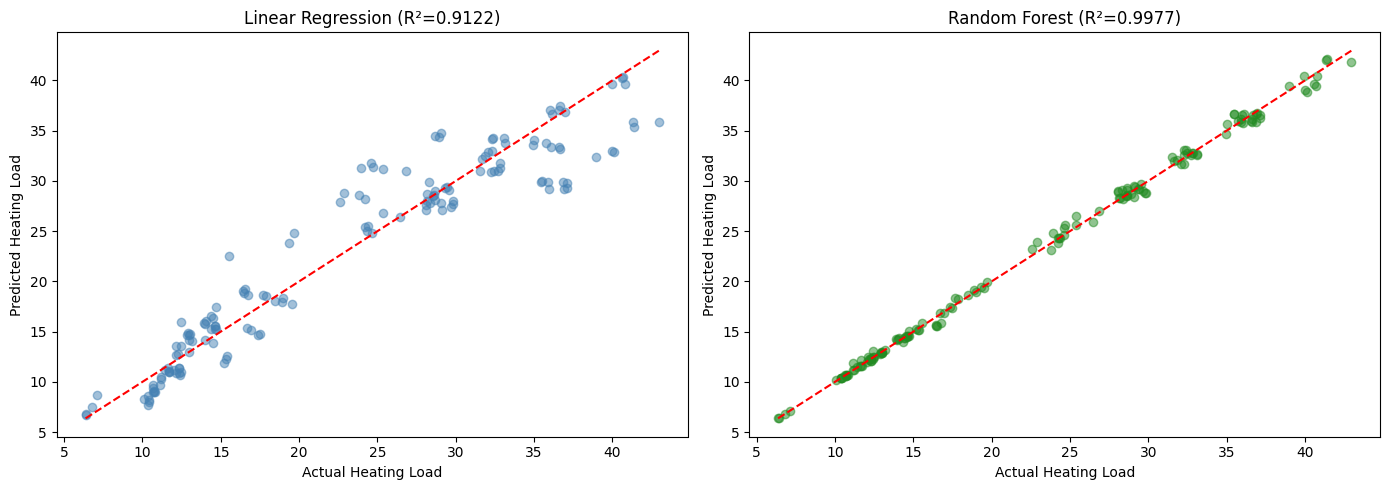

In [12]:
# Actual vs Predicted scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test, y_pred_lr, alpha=0.5, c='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_title(f'Linear Regression (R²={lr_r2:.4f})')
axes[0].set_xlabel('Actual Heating Load')
axes[0].set_ylabel('Predicted Heating Load')

axes[1].scatter(y_test, y_pred_rf, alpha=0.5, c='forestgreen')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1].set_title(f'Random Forest (R²={rf_r2:.4f})')
axes[1].set_xlabel('Actual Heating Load')
axes[1].set_ylabel('Predicted Heating Load')

plt.tight_layout()
plt.show()

## 8. Optimisation — Hyperparameter Tuning (Random Forest)
Since Random Forest is the clear winner, we tune it with GridSearchCV.

In [13]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print(f'\nBest Parameters: {grid_search.best_params_}')
print(f'Best CV R² Score: {grid_search.best_score_:.4f}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV R² Score: 0.9974


In [14]:
# Evaluate tuned model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

best_r2 = r2_score(y_test, y_pred_best)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
best_mae = mean_absolute_error(y_test, y_pred_best)

print('=== Tuned Random Forest Results ===')
print(f'R² Score:  {best_r2:.4f}')
print(f'RMSE:      {best_rmse:.4f} kWh/m²')
print(f'MAE:       {best_mae:.4f} kWh/m²')

=== Tuned Random Forest Results ===
R² Score:  0.9977
RMSE:      0.4903 kWh/m²
MAE:       0.3545 kWh/m²


## 9. Final Comparison — All Three Models

In [15]:
final_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest (Default)', 'Random Forest (Tuned)'],
    'R² Score': [lr_r2, rf_r2, best_r2],
    'RMSE (kWh/m²)': [lr_rmse, rf_rmse, best_rmse],
    'MAE (kWh/m²)': [lr_mae, rf_mae, best_mae]
}).round(4)

print('\n========== FINAL MODEL COMPARISON ==========')
final_comparison


========== FINAL MODEL COMPARISON ==========


,Model,R² Score,RMSE (kWh/m²),MAE (kWh/m²)
0,Linear Regression,0.9122,3.0254,2.1821
1,Random Forest (Default),0.9977,0.4903,0.3545
2,Random Forest (Tuned),0.9977,0.4903,0.3545


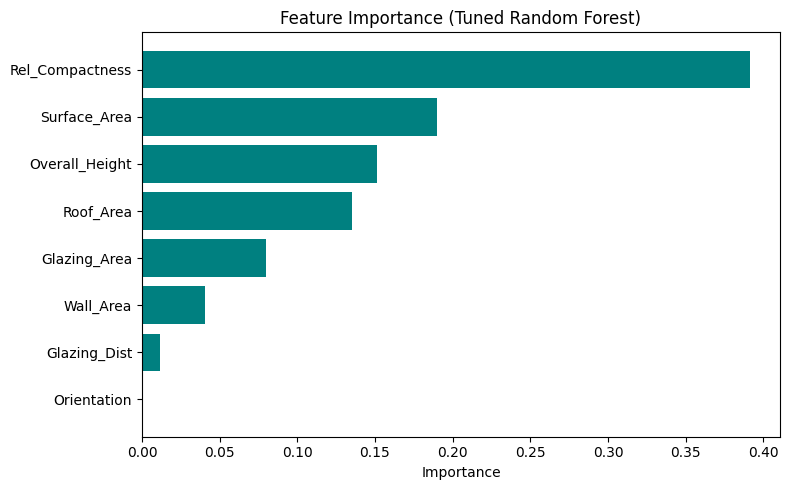

In [16]:
# Feature importance from the tuned model
importances = best_rf.feature_importances_
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='teal')
plt.title('Feature Importance (Tuned Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## 10. Conclusion

| Metric | Linear Regression | Random Forest (Tuned) |
|--------|------------------|-----------------------|
| R² | 0.9122 | 0.9977 |
| RMSE | 3.03 kWh/m² | 0.49 kWh/m² |
| MAE | 2.18 kWh/m² | 0.35 kWh/m² |

**Winner: Random Forest Regressor** — It captures the non-linear interactions between building parameters
far better than Linear Regression, achieving near-perfect prediction accuracy.

**Business Recommendation:** The AECO firm should deploy the Random Forest model to predict
building heating loads from design parameters. This enables early-stage energy cost estimation,
supports LEED/green certification goals, and helps optimise HVAC system sizing during pre-construction.